In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import seaborn as sns
from matplotlib import cm
import sys
import random
from sklearn.metrics import roc_curve,auc

import os
import mpmath as mp
import itertools
from multiprocessing import Process
from multiprocessing import Pool
from sklearn.cluster import KMeans
%matplotlib inline
mp.mp.dps=64



In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #credits - sklearn
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    else:    
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [3]:
listing = os.listdir('./data_set/mountain')


class1=np.empty((1,23))
for infile in listing:
    tmp=np.loadtxt('./data_set/mountain/'+infile)
    tmp=np.average(tmp,axis=0)
    class1 = np.vstack((class1, tmp))
    
listing = os.listdir('./data_set/street')


class2=np.empty((1,23))
for infile in listing:
    tmp=np.loadtxt('./data_set/street/'+infile)
    tmp=np.average(tmp,axis=0)
    class2 = np.vstack((class2, tmp))
    
listing = os.listdir('./data_set/tallbuilding')


class3=np.empty((1,23))
for infile in listing:
    tmp=np.loadtxt('./data_set/tallbuilding/'+infile)
    tmp=np.average(tmp,axis=0)
    class3 = np.vstack((class3, tmp))


def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]


    
'''class1=np.loadtxt('./data_set/syn/class1.txt')
class2=np.loadtxt('./data_set/syn/class2.txt')
np.random.shuffle(class1)
np.random.shuffle(class2)
'''

"class1=np.loadtxt('./data_set/syn/class1.txt')\nclass2=np.loadtxt('./data_set/syn/class2.txt')\nnp.random.shuffle(class1)\nnp.random.shuffle(class2)\n"

In [4]:
class Gaussian:
    
    def __init__(self, mu, sigma):
        
        self.mu = mu
        self.sigma = sigma
        #print mu,sigma
    def pdf_log(self,datum):
        size = len(datum)
        det = np.linalg.det(self.sigma)

        N =  ((2*math.pi)**size * det)**0.5 
        x_mu = (datum - self.mu)
        inv = np.linalg.inv(self.sigma)        
        result = -0.5 * np.matmul(x_mu , np.matmul(inv, np.transpose(x_mu)))
        return  result-np.log(N)
    
    def pdfx(self,datum):
        size = len(datum)
        
        datum=mp.matrix(datum)
        sigma=mp.matrix(self.sigma)
        mu=mp.matrix(self.mu)
        det = mp.det(sigma)
        
        N =  ((2*math.pi)**size * det)**0.5
        
        x_mu = (datum - mu)
        
    
        
        inv = sigma**-1        
        
        #print N,np.array(x_mu.T.tolist()).shape,np.array(inv.tolist()).shape
        result = -0.5 * x_mu.T * (inv* x_mu)
        #print result.tolist()[0][0]
        result=mp.power(math.e,result.tolist()[0][0])
        return  result/N
    
    def pdf(self, datum):
        size = len(datum)
        if(is_invertible(self.sigma)):
            det = np.linalg.det(self.sigma)
        else:
            det = self.sigma.diagonal().prod()
            
        N =  ((2*math.pi)**size * det)**0.5 
        x_mu = (datum - self.mu)
        if is_invertible(self.sigma):
            inv = np.linalg.inv(self.sigma)
        else:
            inv = np.linalg.pinv(self.sigma)
        result = math.pow(math.e, -0.5 * np.matmul(x_mu , np.matmul(inv, np.transpose(x_mu))))
        return  result/N
    def pdf_rl(self, datum):
        size = len(datum)
        det = np.linalg.det(self.sigma)
            
        N =  ((2*math.pi)**size * det)**0.5 
        x_mu = (datum - self.mu)
        inv = np.linalg.inv(self.sigma)
        result = math.pow(math.e, -0.5 * np.matmul(x_mu , np.matmul(inv, np.transpose(x_mu))))
        return  result/N
    
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1})'.format(self.mu, self.sigma)
    

In [5]:
N=class1.shape[0]

c1_train=class1[:int(math.ceil(N*7/10))]
c1_valid=class1[int(math.ceil(N*7/10)):int(math.ceil(N*9/10))]
c1_test=class1[int(math.ceil(N*9/10)):]


N=class2.shape[0]
c2_train=class2[:int(math.ceil(N*7/10))]
c2_valid=class2[int(math.ceil(N*7/10)):int(math.ceil(N*9/10))]
c2_test=class2[int(math.ceil(N*9/10)):]

N=class3.shape[0]
c3_train=class3[:int(math.ceil(N*7/10))]
c3_valid=class3[int(math.ceil(N*7/10)):int(math.ceil(N*9/10))]
c3_test=class3[int(math.ceil(N*9/10)):]


In [6]:
c1_mu=np.mean(c1_train,axis=0)
temp=c1_train.T
c1_sig=np.cov(temp)

c2_mu=np.mean(c2_train,axis=0)
temp=c2_train.T
c2_sig=np.cov(temp)

c3_mu=np.mean(c3_train,axis=0)
temp=c3_train.T
c3_sig=np.cov(temp)





In [7]:
class GaussianMixture:
    
    def __init__(self, data,n):
        self.data = data
        self.N=n
        kmeans = KMeans(n_clusters=n,random_state=0).fit(data)
        
        mu=[]
        for i in range(n):
            mu.append(kmeans.cluster_centers_[i])
        
        #print mu
        '''
        c=[]
        for k in range(n):
            c.append(np.array([i for i in data if kmeans.predict([i])[0]==k]))
        '''
        
        
        
        
        sig=[]
        
        for i in range(n):
            temp=data.T
            sig.append(np.cov(temp))
            
        
        
        self.gas=[]
        for i in range(n):
            self.gas.append(Gaussian(mu[i],sig[i]))
        
        
        self.w = np.full(n,1.0/n)
        
        self.logN=0
    def E(self):
        v=[]
        self.logN=0
        gamma=[]
        for i in self.data:
            gamma=[]
            for k in range(self.N):
                gamma.append(self.gas[k].pdf(i)*self.w[k])
            
            
            total_gamma = sum(gamma)
            
            
            
            for k in range(self.N):
                gamma[k]/=total_gamma
            
            
            #for k in range(self.N):
             #   self.logN += self.gas[k].pdf(i)*self.w[k]
            
            v.append(gamma)
            
        return v

    def M(self,gammas):
        Nk=[]
        for i in range(self.N):
            Nk.append(sum(gammas[:,i]))
            
        
        
        for k in range(self.N):
            self.gas[k].mu=np.sum(i*j for (i,j) in zip(gammas[:,k], self.data))/Nk[k]
        
        for k in range(self.N):
            self.gas[k].sigma=np.sum([(i* (np.outer((j - self.gas[k].mu),np.array(j - self.gas[k].mu)))) for (i,j) in zip(gammas[:,k], self.data)],axis=0)/Nk[k]
            #self.gas[k].sigma=np.clip(self.gas[k].sigma,a_min=1e-3,a_max=1e50)
        for k in range(self.N):
            
            self.w[k]=Nk[k]/len(self.data)
            
        

    def __str__(self):
        return str(self.mu,self.sig)
    
    def likelihood(self,x):
        val=0
        for i in range(self.N):
            val+=self.gas[i].pdf_rl(x)*(self.w[i])
        return val
    
    def likelihood_test(self,x):
        val=0
        for i in range(self.N):
            val+=self.gas[i].pdf(x)*(self.w[i])
        return val
    
    

In [8]:
def trainer(iters,mixnumber):
    global mix
    
    for i in range(iters):
        v=mix[mixnumber].E()
        v=np.array(v)
        mix[mixnumber].M(v)
    return

def testerl(mixnumber):
    if mixnumber==0:
        samples=c1_valid
    elif mixnumber==1:
        samples=c2_valid
    else:
        samples=c3_valid
    total=0
    tx=0
    for s in samples:
        total+=1
        tmp=[mix[0].likelihood_test(s),mix[1].likelihood_test(s),mix[2].likelihood_test(s)]
        i=tmp.index(max(tmp))
        if i==mixnumber:
            tx+=1
    return tx*1.0/total


        

accs=[]
mix=[]
clusters=4
iters = 2

oldN=0

mix.append( GaussianMixture(c1_train,clusters))#c2_train,4)

thread0 = Process(
            target=trainer,
            name="class0",
            args=[iters, 0],
            )
thread0.start()



oldN=0
mix.append(GaussianMixture(c2_train,clusters))#c2_train,4)

thread1 = Process(
            target=trainer,
            name="class1",
            args=[iters, 1],
            )
thread1.start()



oldN=0
mix.append( GaussianMixture(c3_train,clusters))#c2_train,4)
thread2 = Process(
            target=trainer,
            name="class2",
            args=[iters, 2],
            )
thread2.start()

thread0.join()
thread1.join()
thread2.join()

print 'trained...'




for m in mix:
    for g in m.gas:
        g.mu=np.array(g.mu.tolist(),dtype=np.float64)
        g.sigma=np.array(g.sigma.tolist(),dtype=np.float64)


p=Pool()
a=p.map(testerl, [0,1,2])
print a
print 'c = ',clusters*2,' accuracy = ',a
accs.append([clusters*2,np.mean(a)])






ax = plt.gca()
accs=np.array(accs)

ax.plot(accs[:,0],accs[:,1])
plt.savefig('./results/real_full',format='eps')
    
plt.show()



trained...
c =  2  accuracy =  0.809756097561


/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


trained...
c =  4  accuracy =  0.809756097561


/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/mak/anaconda2/lib/python2.7/site-packages/ipykernel_l

trained...
c =  8  accuracy =  0.809756097561


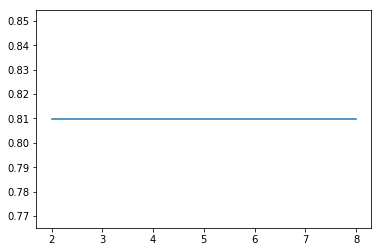

In [9]:
accs=[]
mix=[]
models=[]
for clusters in [1,2,4]:
    
    mix=[]
    iters = 2

    oldN=0

    mix.append( GaussianMixture(c1_train,clusters))#c2_train,4)

    thread0 = Process(
                target=trainer,
                name="class0",
                args=[iters, 0],
                )
    thread0.start()



    oldN=0
    mix.append(GaussianMixture(c2_train,clusters))#c2_train,4)

    thread1 = Process(
                target=trainer,
                name="class1",
                args=[iters, 1],
                )
    thread1.start()

    

    oldN=0
    mix.append( GaussianMixture(c3_train,clusters))#c2_train,4)
    thread2 = Process(
                target=trainer,
                name="class2",
                args=[iters, 2],
                )
    thread2.start()

    thread0.join()
    thread1.join()
    thread2.join()

    print 'trained...'
    models.append(mix)


    p=Pool()
    a=np.average(p.map(testerl, [0,1,2]),weights=[len(c1_valid),len(c2_valid),len(c3_valid)])
    
    
    print 'c = ',clusters*2,' accuracy = ',a
    accs.append([clusters*2,a])
    

    
    

    if a==1.0:
        break


ax = plt.gca()
accs=np.array(accs)

ax.plot(accs[:,0],accs[:,1])
#plt.savefig('./results/real_full',format='eps')
    
plt.show()



Confusion matrix, without normalization
[[ 30.   5.   3.]
 [  1.  23.   6.]
 [  3.   2.  31.]]


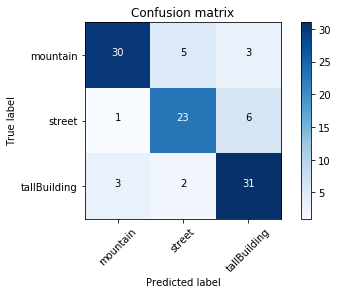

Normalized confusion matrix
[[ 0.78947368  0.13157895  0.07894737]
 [ 0.03333333  0.76666667  0.2       ]
 [ 0.08333333  0.05555556  0.86111111]]


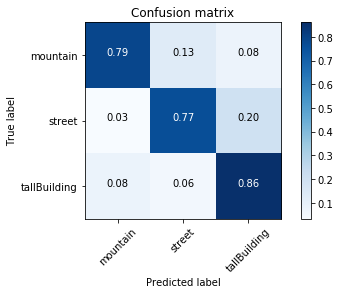

Confusion matrix, without normalization
[[ 30.   5.   3.]
 [  1.  23.   6.]
 [  3.   2.  31.]]


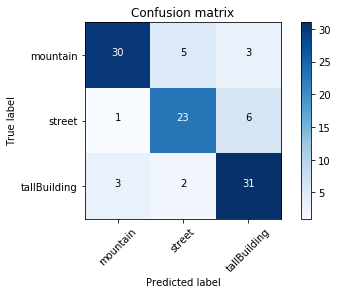

Normalized confusion matrix
[[ 0.78947368  0.13157895  0.07894737]
 [ 0.03333333  0.76666667  0.2       ]
 [ 0.08333333  0.05555556  0.86111111]]


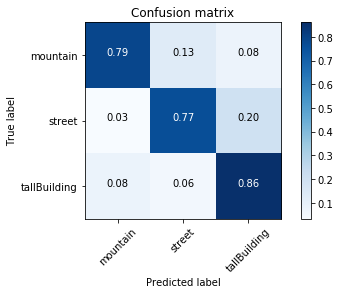

Confusion matrix, without normalization
[[ 28.   7.   3.]
 [  1.  23.   6.]
 [  3.   4.  29.]]


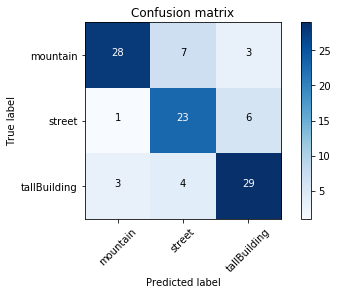

Normalized confusion matrix
[[ 0.73684211  0.18421053  0.07894737]
 [ 0.03333333  0.76666667  0.2       ]
 [ 0.08333333  0.11111111  0.80555556]]


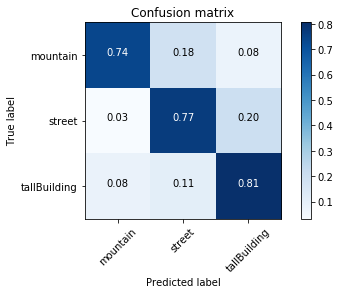

In [41]:
#conf matrix
cl=2
all_predictions=[]
for mix1,mix2,mix3 in models:
    cf=np.zeros((3,3))
    count=0
    #print 'testing class1'
    predictions0=[]
    scores=[]
    for s in c1_test:

        tmp=[mix1.likelihood(s),mix2.likelihood(s),mix3.likelihood(s)]
        a=[0,tmp[0]/sum(tmp),tmp[1]/sum(tmp),tmp[2]/sum(tmp)]
        scores.append(a)
        i=tmp.index(max(tmp))
        predictions0.append([0,i])
        cf[0,i]+=1
        

    for s in c2_test:

        tmp=[mix1.likelihood(s),mix2.likelihood(s),mix3.likelihood(s)]
        a=[1,tmp[0]/sum(tmp),tmp[1]/sum(tmp),tmp[2]/sum(tmp)]
        scores.append(a)
        
        i=tmp.index(max(tmp))
        predictions0.append([1,i])
        
        cf[1,i]+=1
    
    for s in c3_test:

        tmp=[mix1.likelihood(s),mix2.likelihood(s),mix3.likelihood(s)]
        a=[2,tmp[0]/sum(tmp),tmp[1]/sum(tmp),tmp[2]/sum(tmp)]
        scores.append(a)
        
        i=tmp.index(max(tmp))
        predictions0.append([1,i])
        cf[2,i]+=1
    
    
    all_predictions.append(predictions0)
    plot_confusion_matrix(cf,['mountain','street','tallBuilding'])
    plt.savefig('./results_real/syn_full_conf_k='+str(cl),format='eps')
    
    plt.show()
    plot_confusion_matrix(cf,['mountain','street','tallBuilding'],normalize=True)
    plt.savefig('./results_real/syn_full_conf_nrmlzd_k='+str(cl),format='eps')
    
    plt.show()
    
    np.savetxt('./'+str(cl)+'.txt',scores,fmt='%d %f %f %f',delimiter=',')
    cl*=2

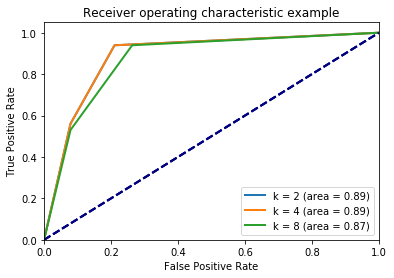

In [11]:
plt.figure()
i=2
for predictions in all_predictions:
    #for predictions in pred:
    predictions=np.array(predictions)
    #print predictions
    fpr, tpr, _ = roc_curve(predictions[:,0], predictions[:,1])
    roc_auc = auc(fpr, tpr)
    #print fpr,tpr
    lw = 2
    plt.plot(fpr, tpr, 
             lw=lw, label='k = %d (area = %0.2f)'%(i,roc_auc))
    i=i*2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('./results_real/roc',format='eps')
plt.show()

Confusion matrix, without normalization
[[ 90.  20.   2.]
 [  4.  79.   4.]
 [ 19.  42.  45.]]


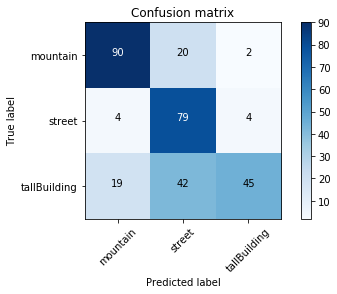

ValueError: shape too large to be a matrix.

In [45]:

cf=np.matrix([[90.,20.,2.],[4.,79.,4.],[19.,42.,45.]])

plot_confusion_matrix(cf,['mountain','street','tallBuilding'])
plt.savefig('./conf.eps',format='eps')
plt.show()

plot_confusion_matrix(cf,['mountain','street','tallBuilding'],normalize=True)
plt.savefig('./conf_norm.eps',format='eps')
plt.show()